In [1]:
import pandas as pd
import tensorflow as tf

In [2]:
df=pd.read_csv("Data/Data/features_3_sec.csv")

In [3]:
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [4]:
df.shape

(9990, 60)

In [5]:
print("Columns containing missing values",list(df.columns[df.isnull().any()]))

Columns containing missing values []


In [6]:
df.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

In [7]:
df['label'].value_counts()

label
blues        1000
jazz         1000
metal        1000
pop          1000
reggae       1000
disco         999
classical     998
hiphop        998
rock          998
country       997
Name: count, dtype: int64

In [8]:
from sklearn.preprocessing import LabelEncoder
class_encod=df.iloc[:,-1]
converter=LabelEncoder()
y=converter.fit_transform(class_encod)
y

array([0, 0, 0, ..., 9, 9, 9])

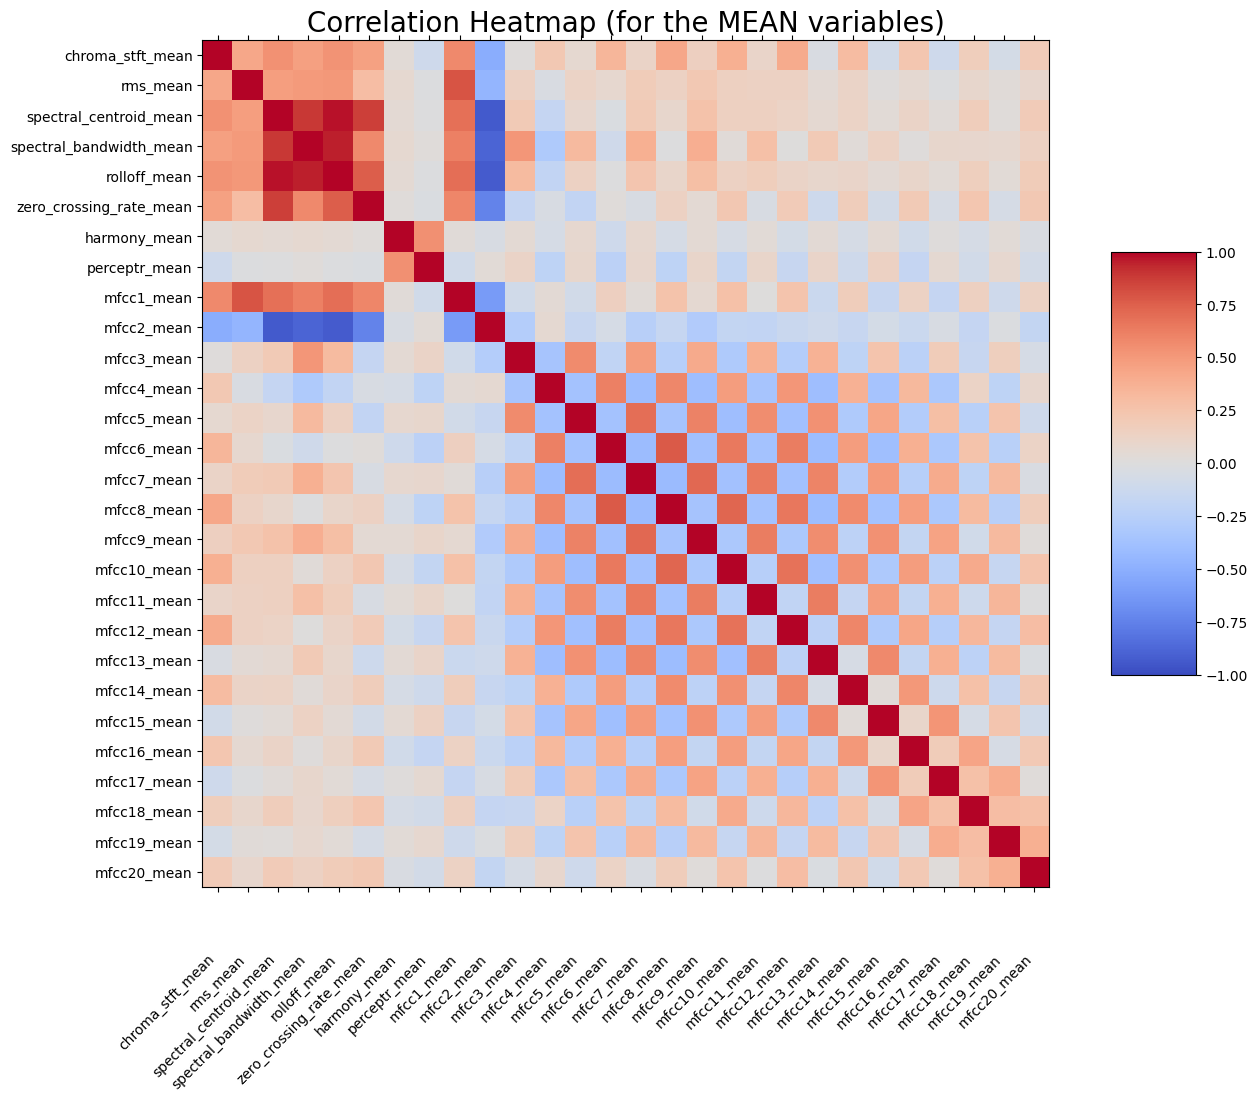

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(16, 11))

# Draw the heatmap with the mask and correct aspect ratio
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)

# Draw colorbar
fig.colorbar(cax, shrink=0.5, aspect=5)

# Set up labels
labels = [col.replace('mean_', '') for col in spike_cols]
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor",y=-0.1)

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig("Corr_Heatmap.png")
plt.show()

In [9]:
df=df.drop(labels="filename",axis=1)

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [12]:
import numpy as np
from sklearn.preprocessing import StandardScaler
fit=StandardScaler()
X=fit.fit_transform(np.array(df.iloc[:,:-1],dtype=float))

In [16]:
len(X_train) # finding length

6993

In [14]:
def train_model(model,epochs,optimizer):
    batch_size=256
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=batch_size, callbacks=[])

In [15]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(df.drop('label',axis=1).shape[1],)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(10,activation='softmax'),
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.summary()
model_history=train_model(model=model,epochs=500,optimizer=optimizer)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 58)                0         
                                                                 
 dropout (Dropout)           (None, 58)                0         
                                                                 
 dense (Dense)               (None, 512)               30208     
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               

In [17]:
model.save('model1.h5')

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
test_loss,test_acc=model.evaluate(X_test,y_test,batch_size=256)
print("The test loss is ",test_loss)
print("The best accuracy is: ",test_acc*100)

12/12 [==============================] - 0s 8ms/step - loss: 0.2322 - accuracy: 0.9369
The test loss is  0.2322232872247696
The best accuracy is:  93.69369149208069
